In [ ]:
import tensorflow as tf
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
IMG_BATCH_SIZE = 64
IMG_SIZE = 224

# Dataset fetching and Exploration

In [ ]:
import kagglehub

path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
print("Path to dataset files:", path)

100%|██████████| 161M/161M [00:09<00:00, 17.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/versions/1


In [ ]:
!ls $path/data/

Blight	Common_Rust  Gray_Leaf_Spot  Healthy


In [ ]:
print(path)

/root/.cache/kagglehub/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/versions/1


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(f"{path}/data/", batch_size=IMG_BATCH_SIZE, image_size=(IMG_SIZE, IMG_SIZE), seed=21, validation_split=0.2,
  subset="validation")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(f"{path}/data/", batch_size=IMG_BATCH_SIZE, image_size=(IMG_SIZE, IMG_SIZE), seed=21, validation_split=0.2,
  subset="validation")

Found 4188 files belonging to 4 classes.
Using 837 files for validation.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [ ]:
for image, label in train_ds:
    print(image.shape)
    break

(64, 224, 224, 3)


In [ ]:
class_names = train_ds.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

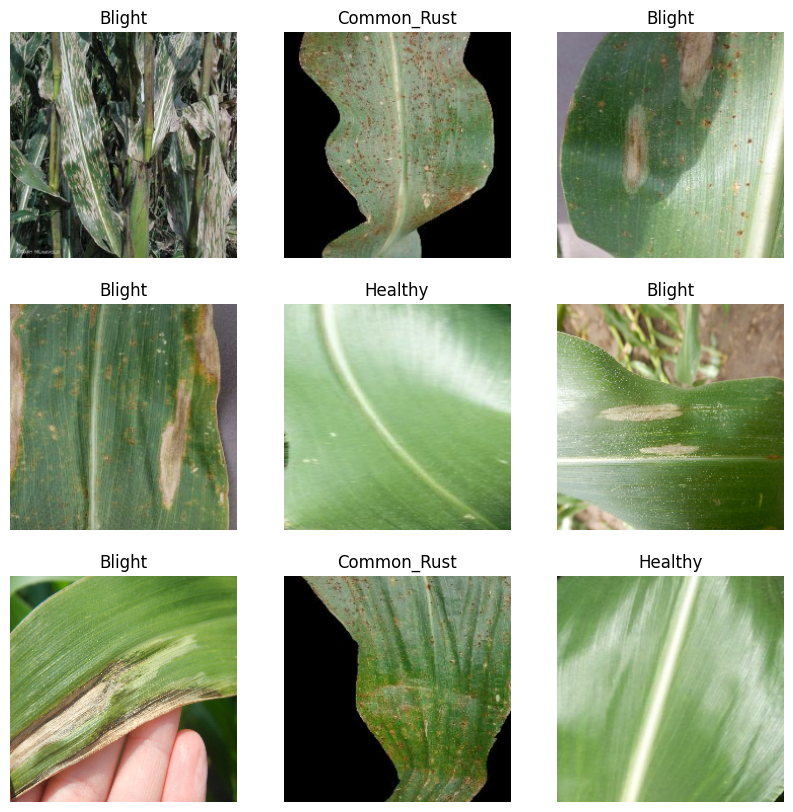

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model_1

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

In [ ]:
def preprocess_and_augment(image, label):
    # Preprocessing: Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0

    # Data Augmentation
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, 0.8, 1.2)  # Random contrast

    return image, label


In [ ]:
class CNNAttnModel(tf.keras.Model):
    def __init__(self, num_classes=4, token_dim=224, num_mla_heads=4, num_patches=49):
        super(CNNAttnModel, self).__init__()
        self.num_classes=num_classes
        self.inp_layer = tf.keras.layers.Input(shape=(224, 224, 3))
        # Stage 1: Local Feature Extraction
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(32, (7,7), strides=(4,4), padding='same'),
            tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256)
        ])
        self.token_dim = token_dim
        self.num_patches = num_patches
        self.positional_encoding = self._create_positional_encoding(self.num_patches, token_dim)

        # Stage 2: MultiHead Self Attention
        self.stage_2 = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(49, 256)),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MultiHeadAttention(num_heads=num_mla_heads, key_dim=token_dim// num_mla_heads),
        ])
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='gelu'),
            tf.keras.layers.Dense(token_dim)
        ])

        # Stage 3: Classification
        self.dense = tf.keras.layers.Dense(num_classes)


    def _create_positional_encoding(self, num_patches, token_dim):
        """
        Generates a learnable positional encoding tensor.
        """

        return tf.Variable(
            tf.random.normal([num_patches, token_dim]),
            trainable=True,
            name="positional_encoding"
        )


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        print("Input: ", inputs.shape)
        # Stage 1:
        ## For each image from dataset: cut into 49 sections
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, 32, 32, 1],
            strides=[1, 32, 32, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )  # Output: [batch_size, 7, 7, 3 * 32 * 32]

        patches = tf.reshape(patches, [batch_size, 49, 32, 32, 3]) # Explicitly reshape to 49 patches

        ## For each section of image: Send into CNN (Conv2D, Maxpool, Flatten)
        tokens = tf.map_fn(lambda patch: self.cnn(patch), patches, dtype=tf.float32)

        print("\nAfter CNN: ", tokens.shape)
        # ### Stack all flattened tokens in one tensor (say X)
        # tokens = tf.concat(tokens, axis=1)
        # print("\nAfter concat: ", tokens.shape)
        ### Find positional encoding of each token and append to X.
        tokens += self.positional_encoding
        print("\nAfter adding positional encoding: ", tokens.shape)
        # Stage 2
        attn_output = self.stage_2(tokens)
        print("\nAfter stage 2: ", attn_output.shape)
        # ## Layer Normalization of Flattened tensors
        x = self.layer_norm1(tokens)
        print("\nAfter layer norm: ", x.shape, x[0])
        # ## Multi head attention (4 heads yielding 4 outputs)
        attn_output, attention_scores = self.mha(x, x, x, return_attention_scores=True)
        print("\nAfter mha: ", attn_output.shape, attention_scores)
        ## Combine all 4 tensor outputs from 4 heads using oplus operator (say Y)
        x = x + attn_output
        print("\nAfter adding mha: ", x.shape)
        ## Layer Normalization of Y
        x = self.layer_norm2(attn_output)
        print("\nAfter layer norm 2: ", x.shape)
        ## Pass Y into MLP using Gaussian error linear units (GELU) activation function. (say we get output W)
        x = x + self.mlp(x)
        print("\nAfter adding mlp: ", x.shape)

        # Stage 3:
        ## Linearlizaing Q into one dim tensor say L
        x = tf.reduce_mean(x, axis=1)
        print("\nAfter reducing mean: ", x.shape)
        ## Pass L into dense layer
        logits = self.dense(x)
        print("\nAfter dense: ", logits.shape)
        res_prob = tf.keras.layers.Activation('softmax')(logits)
        return res_prob

In [ ]:
# Apply preprocessing and augmentation to training data
train_dataset = train_ds.map(preprocess_and_augment)

# Apply only normalization to validation data
def preprocess_only(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label

validation_dataset = test_ds.map(preprocess_only)

In [ ]:
# Instantiate model
model = CNNAttnModel(num_classes=4, token_dim=256, num_mla_heads=4)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

ValueError: Layers added to a Sequential model can only have a single positional argument, the input tensor. Layer MultiHeadAttention has multiple positional arguments: [<Parameter "query">, <Parameter "value">]

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=12
)

NameError: name 'model' is not defined

# Model 2

In [ ]:
class CNNAttnModel2(tf.keras.Model):
    def __init__(self, num_classes=4, num_mla_heads=4, num_patches=49, image_size=(224, 224, 3)):
        super(CNNAttnModel2, self).__init__()
        self.inp_layer = tf.keras.layers.Input(shape=image_size)
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(32, (7,7), strides=(4,4), padding='same'),
            tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
            tf.keras.layers.Flatten()
        ])
        s


# Model 3

In [ ]:
NUM_IMAGE_CUTS = 49
NUM_LINE = 7
CUT_D = int(IMG_SIZE/(NUM_IMAGE_CUTS/7))

In [ ]:
def get_image_in_parts(image: tf.Tensor, label: tf.Tensor, num_parts: int):
    """
    Splits input image in num_parts of equal dimensions with repeated labels.
    """

    grid_size = num_parts


In [ ]:
def get_image_in_parts(image: tf.Tensor, label: tf.Tensor):
    """
    Splits each image in a batch into parts based on IMAGE_CUTS and repeats labels.

    Args:
    - image: A batched TensorFlow tensor representing the images (batch_size, height, width, channels).
    - label: A batched tensor of labels corresponding to the images (batch_size,).

    Returns:
    - A tuple of (image parts tensor, label tensor).
    """
    # Calculate grid shape
    grid_size = int(IMAGE_CUTS ** 0.5)  # e.g., 4 for a 4x4 grid
    patch_height = IMG_SIZE // grid_size
    patch_width = IMG_SIZE // grid_size

    # Split images into parts
    image_parts = tf.image.extract_patches(
        images=image,
        sizes=[1, patch_height, patch_width, 1],
        strides=[1, patch_height, patch_width, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Reshape to separate each part
    batch_size = tf.shape(image_parts)[0]
    num_parts = grid_size * grid_size
    image_parts = tf.reshape(image_parts, [batch_size * num_parts, patch_height, patch_width, 3])

    # Repeat labels for each part
    repeated_labels = tf.repeat(label, num_parts)

    return image_parts, repeated_labels

In [ ]:
for images, labels in train_ds.take(1):
    for i in range(1):
        im = images[i]

In [ ]:
grid_shape = int(im.shape[0]/(IMAGE_CUTS/NUM_IMG))
grid_shape

32

In [ ]:
im.shape

TensorShape([224, 224, 3])

In [ ]:
row_ctr = 0
col_ctr = 0
im_list = []
for cut in range(IMAGE_CUTS):
    im_list.append(im[row_ctr:CUT_DIM, col_ctr:CUT_DIM])
    if col_ctr == 3:
        col_ctr = 0
        row_ctr += 1
    col_ctr += 1

In [ ]:
im_list[0].shape, len(im_list)

(TensorShape([32, 32, 3]), 49)

In [ ]:
def get_image_in_parts(image: tf.Tensor):
    grid_shape = int(image.shape[0]/(IMAGE_CUTS/NUM_IMG))
    row_ctr = 0
    col_ctr = 0
    im_list = []
    for cut in range(IMAGE_CUTS):
        im_list.append(image[row_ctr:CUT_DIM, col_ctr:CUT_DIM])
        if col_ctr == 3:
            col_ctr = 0
            row_ctr += 1
        col_ctr += 1

    return im_list

In [ ]:
get_image_in_parts(im)[0].shape

TensorShape([32, 32, 3])

In [ ]:
new_train_ds = []

for batch, label in train_ds.take(10):
    for image in batch:
        im_list = get_image_in_parts(image)
        new_train_ds.append(im_list)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),

    # CNN
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),

    #
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 480s 9s/step - accuracy: 0.1370 - loss: 17.3473 - val_accuracy: 0.2557 - val_loss: 14.8187
Epoch 2/5
38/53 ━━━━━━━━━━━━━━━━━━━━ 2:03 8s/step - accuracy: 0.2755 - loss: 13.5428

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Positional Encoding Function
def positional_encoding(length, depth):
    """
    Generate positional encoding for the given length and depth.
    """
    positions = tf.range(length)[:, tf.newaxis]
    depths = tf.range(depth)[tf.newaxis, :] / depth
    angle_rates = 1 / tf.pow(10000.0, (2 * (depths // 2)) / depth)
    angle_rads = positions * angle_rates
    angle_rads = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
    return angle_rads

# Define the Model
class AttentionModel(tf.keras.Model):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4):
        super(AttentionModel, self).__init__()

        # Augmentation and Preprocessing Layers
        self.rescale = layers.Rescaling(1.0 / 255)
        self.augmentation = models.Sequential([
            layers.RandomBrightness(0.2),
            layers.RandomContrast(0.2),
            layers.RandomFlip(),
            layers.RandomRotation(0.2)
        ])

        # CNN Backbone
        self.conv1 = layers.Conv2D(64, (7, 7), activation='relu')
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=2)
        self.flatten = layers.Flatten()

        # Multi-Head Attention and MLP
        self.mha = layers.MultiHeadAttention(num_heads=4, key_dim=64)
        self.layernorm1 = layers.LayerNormalization()
        self.mlp = models.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu')
        ])
        self.layernorm2 = layers.LayerNormalization()
        self.dense_out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Preprocessing
        x = self.rescale(inputs)
        x = self.augmentation(x)

        # Check and adjust dimensions using tf.cond
        x = tf.cond(tf.equal(tf.rank(x), 3), lambda: tf.expand_dims(x, axis=0), lambda: x)

        # CNN Features
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.flatten(x)

        # Positional Encoding
        length = tf.shape(x)[1]
        depth = tf.shape(x)[-1]
        pos_enc = positional_encoding(length, depth)
        # Reshape positional encoding to match the flattened features
        pos_enc = tf.reshape(pos_enc, (tf.shape(x)[0], tf.shape(x)[1]))
        x += pos_enc

        # Multi-Head Attention
        # Reshape to add a dimension for the attention mechanism
        x = tf.expand_dims(x, axis=1)
        x = self.mha(x, x)
        x = tf.reduce_sum(x, axis=1)  # Aggregate across attention heads
        x = self.layernorm1(x)

        # MLP and Output
        x = self.mlp(x)
        x = self.layernorm2(x)
        return self.dense_out(x)


# Instantiate and Compile the Model
model = AttentionModel(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'attention_model_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "attention_model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_6               │ ?                           │     0 (unbuilt) │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_12               │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_13               │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(processed_train_ds, epochs=10)

Epoch 1/10


ValueError: Exception encountered when calling AttentionModel.call().

[1mas_list() is not defined on an unknown TensorShape.[0m

Arguments received by AttentionModel.call():
  • inputs=tf.Tensor(shape=(32, 32, 3), dtype=float32)